In [1]:
# to access functions from other locations
import sys
sys.path.append('/data/ad181/RemoteDir/rl_robust_owc')

In [2]:
%matplotlib notebook
import numpy as np
import time
import matplotlib.pyplot as plt
import pickle
from stable_baselines3.ppo import PPO
from stable_baselines3.a2c import A2C
import os

from utils.plot_functions import plot_rl, plot_k_array, plot_learning_tr, plot_actions, plot_rewards
from utils.env_evaluate_functions import eval_actions, eval_model
from utils.data_handling import get_mean_tr_data, get_sar_data, get_sar_data_wo_base_de
from utils.env_wrappers import StateCoarse

import matplotlib
matplotlib.rcParams['text.usetex'] = True

/home/ad181/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ad181/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ad181/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ad181/anaconda3/lib/python3.7/site-packages/tensorboard/co

In [3]:
case='case_2'

ppo_dir_frozen='../ppo/data/case_2_ppo_frozen'
ppo_dir = '../ppo/data/case_2_ppo'
ppo_dir_full = '../ppo/data/case_2_ppo_full_state'
a2c_dir = '../a2c/data/case_2_a2c'
opt_dir = '../de/case_2'

data_dir = './'+case
os.makedirs(data_dir, exist_ok=True)

# Learning Plots

<IPython.core.display.Javascript object>


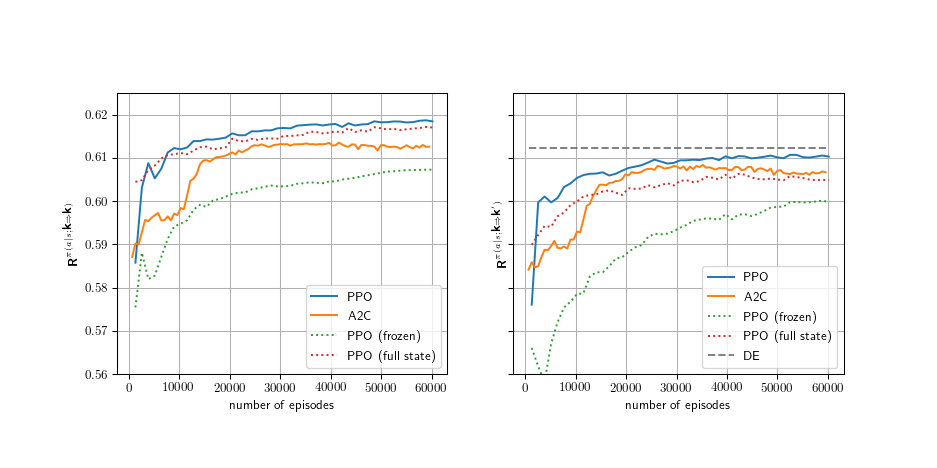

In [4]:
# Learning plot (Training) data
t_ppo_train, r_ppo_train = get_mean_tr_data(ppo_dir, seeds=[1,2,3], result_type='train', episode_len=5)
t_ppo_train_full, r_ppo_train_full = get_mean_tr_data(ppo_dir_full, seeds=[1,2,3], result_type='train', episode_len=5)
t_ppo_train_frozen, r_ppo_train_frozen = get_mean_tr_data(ppo_dir_frozen, seeds=[1,2,3], result_type='train', episode_len=5)
t_a2c_train, r_a2c_train = get_mean_tr_data(a2c_dir, seeds=[1,2,3], result_type='train', episode_len=5)

# Learning plot (Evaluation) data
t_ppo_eval, r_ppo_eval = get_mean_tr_data(ppo_dir, seeds=[1,2,3], result_type='eval', episode_len=5)
t_ppo_eval_full, r_ppo_eval_full = get_mean_tr_data(ppo_dir_full, seeds=[1,2,3], result_type='eval', episode_len=5)
t_ppo_eval_frozen, r_ppo_eval_frozen = get_mean_tr_data(ppo_dir_frozen, seeds=[1,2,3], result_type='eval', episode_len=5)
t_a2c_eval, r_a2c_eval = get_mean_tr_data(a2c_dir, seeds=[1,2,3], result_type='eval', episode_len=5)

fig, axs = plt.subplots(1,2,figsize=(10,5), sharey=True)
plt.subplots_adjust( bottom=0.2, top=0.8, wspace=None, hspace=None)
plot_learning_tr([t_ppo_train, t_a2c_train], 
                 [r_ppo_train, r_a2c_train], 
                 axs[0], legends=['PPO', 'A2C'], window=1,
                 x_label='number of episodes',
                 y_label=r'$\textbf{R}^{\pi(a|s; \textbf{k} \Rightarrow \textbf{k})}$')
axs[0].plot(t_ppo_train_frozen, r_ppo_train_frozen, ':')
axs[0].plot(t_ppo_train_full, r_ppo_train_full, ':')
axs[0].set_ylim([0.56,0.625])
axs[0].legend(['PPO ', 'A2C', 'PPO (frozen)', 'PPO (full state)'])

# get de benchmark value
opt_array=[]
for i in range(16):
    opt_array.append(np.load(opt_dir+'/ck_max_'+str(i)+'.npy'))

plot_learning_tr([t_ppo_eval, t_a2c_eval], 
                 [r_ppo_eval, r_a2c_eval], 
                 axs[1],legends=['PPO', 'A2C'], ref_value=-np.mean(opt_array), window=1,
                 x_label='number of episodes',
                 y_label=r"$\textbf{R}^{\pi(a|s; \textbf{k} \Rightarrow \textbf{k}')}$")
axs[1].plot(t_ppo_eval_frozen, r_ppo_eval_frozen, ':')
axs[1].plot(t_ppo_eval_full, r_ppo_eval_full, ':')
axs[1].legend(['PPO ', 'A2C', 'PPO (frozen)', 'PPO (full state)', 'DE'])

fig.savefig(data_dir+'/'+case+'_rl_plot.pdf')

# Training and Evaluation Permeabilities

<IPython.core.display.Javascript object>


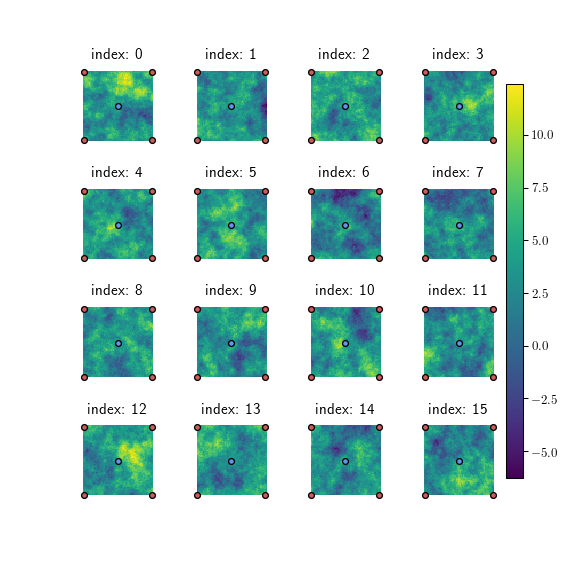

In [5]:
with open('../envs_params/env_data/env_train.pkl', 'rb') as input:
    env_train = pickle.load(input)
k_train = np.load('../envs_params/env_data/k_log_md_train_clustered.npy')
fig = plot_k_array(k_train, env_train.q.copy(), rows=4, cols=4, marker_size=20)
fig.savefig(data_dir+'/'+case+'_k_train.pdf')

<IPython.core.display.Javascript object>


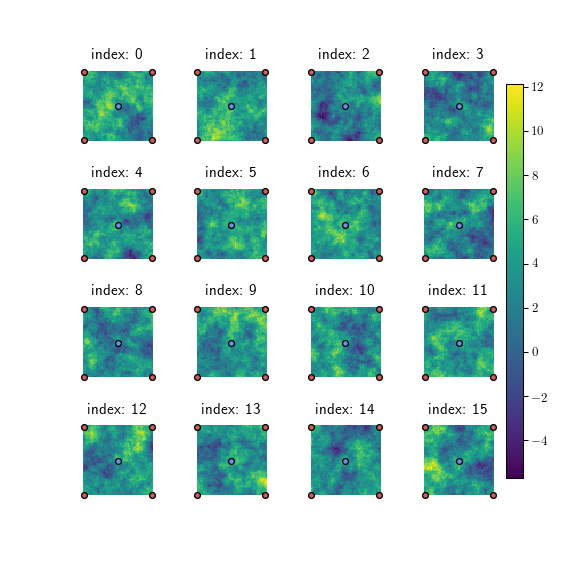

In [6]:
k_eval = np.load('../envs_params/env_data/k_log_md_eval_clustered.npy')
fig = plot_k_array(k_eval, env_train.q.copy(), rows=4, cols=4, marker_size=20)
fig.savefig(data_dir+'/'+case+'_k_eval.pdf')

In [7]:
# env wrapper to reduce state space
x_coords, y_coords = env_train.p_x, env_train.p_y

def env_wrappers(env, x_coords, y_coords, include_pr=True):
    env = StateCoarse(env, x_coords, y_coords, include_well_pr=include_pr)
    return env

# Plots results

In [8]:
# data gathering
seed=3
model_ppo = PPO.load(ppo_dir+'/seed_'+str(seed)+'/best_model_eval/best_model')
model_a2c = A2C.load(a2c_dir+'/seed_'+str(seed)+'/best_model_eval/best_model')

with open('../envs_params/env_data/env_list_eval.pkl', 'rb') as input:
    envs = pickle.load(input)
    
envs_coarse = []
for env in envs:
    env = env_wrappers(env, x_coords, y_coords)
    envs_coarse.append(env)
  
models=[model_ppo, model_a2c]
model_names = ['PPO', 'A2C']
model_base_steps = 1

s_array_eval, a_array_eval, r_array_eval, case_names_eval = get_sar_data(envs_coarse, list(range(16)),
                                                                         opt_dir,
                                                                         models, model_names, model_base_steps = 1)

<IPython.core.display.Javascript object>


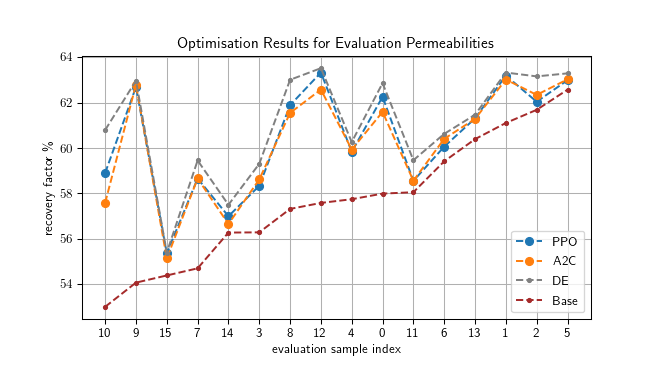

In [9]:
# plot rewards (oil recovery)
fig, axs = plt.subplots(1,1,figsize=(7,4))
plt.subplots_adjust(left=None,bottom=0.15,right=None,top=0.85,wspace=0.1,hspace=0.1)
plot_rewards(r_array_eval, axs, model_names=['PPO', 'A2C'])
fig.savefig(data_dir+'/'+case+'_r_eval.pdf')

<IPython.core.display.Javascript object>


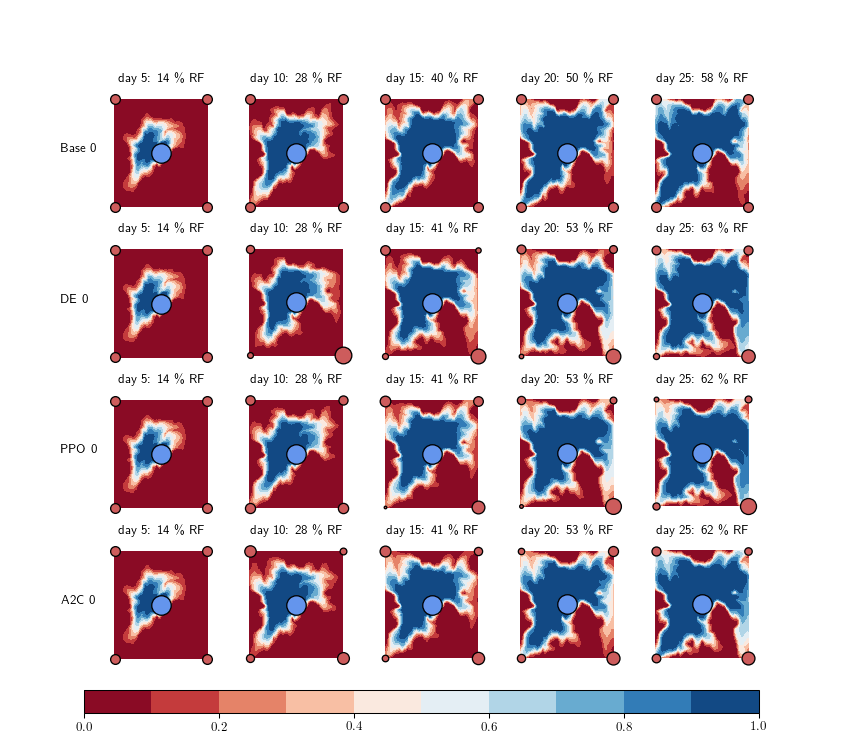

<IPython.core.display.Javascript object>


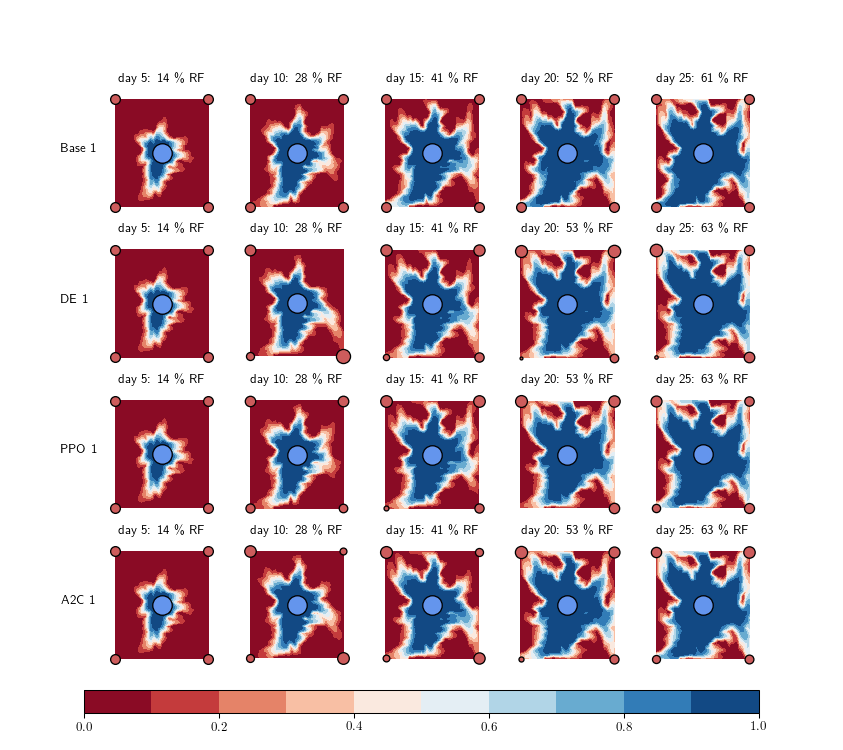

<IPython.core.display.Javascript object>


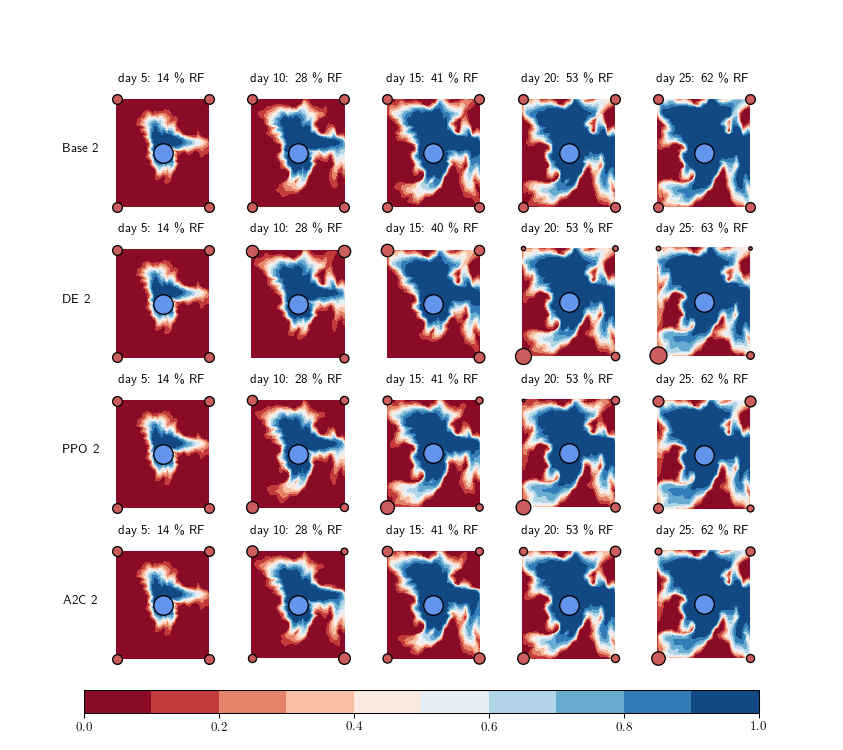

<IPython.core.display.Javascript object>


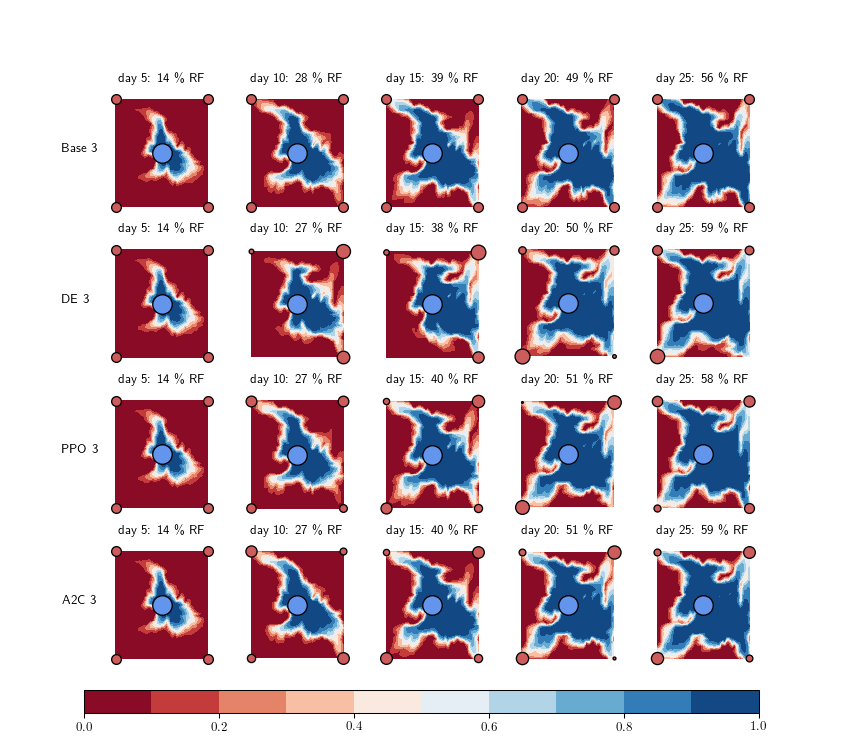

<IPython.core.display.Javascript object>


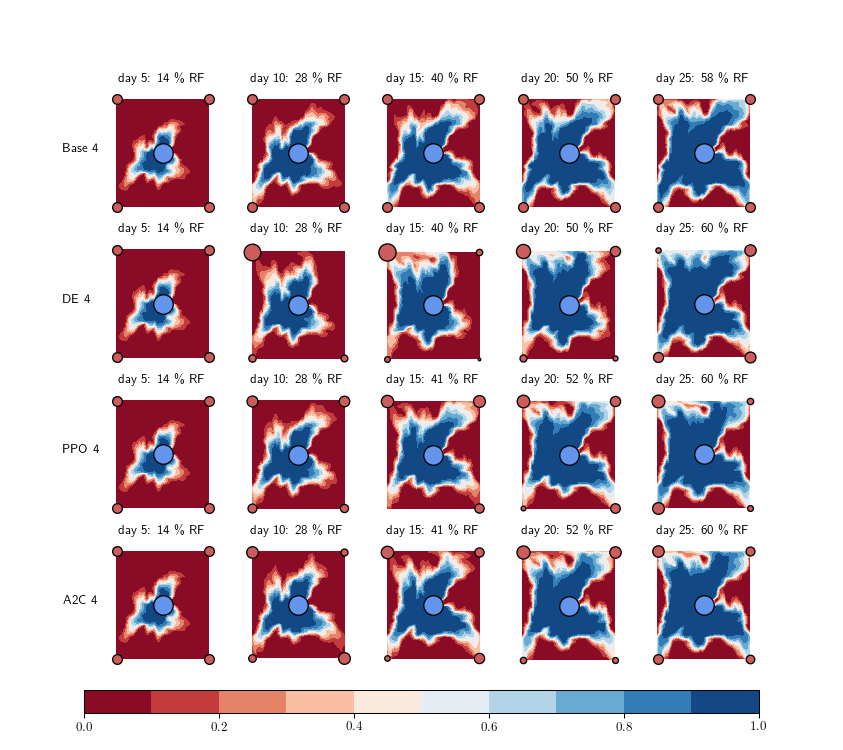

<IPython.core.display.Javascript object>


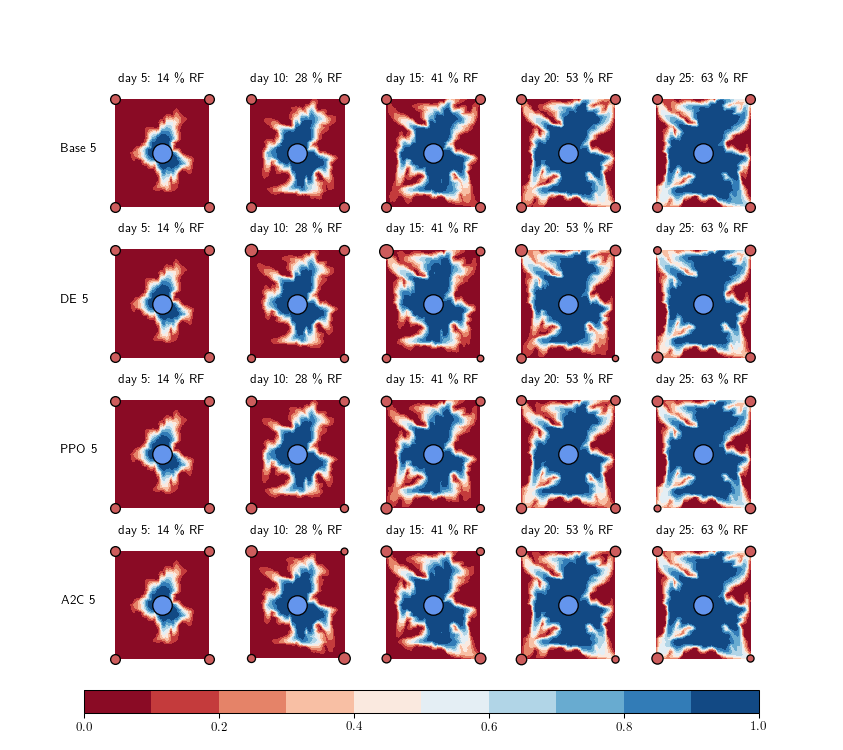

<IPython.core.display.Javascript object>


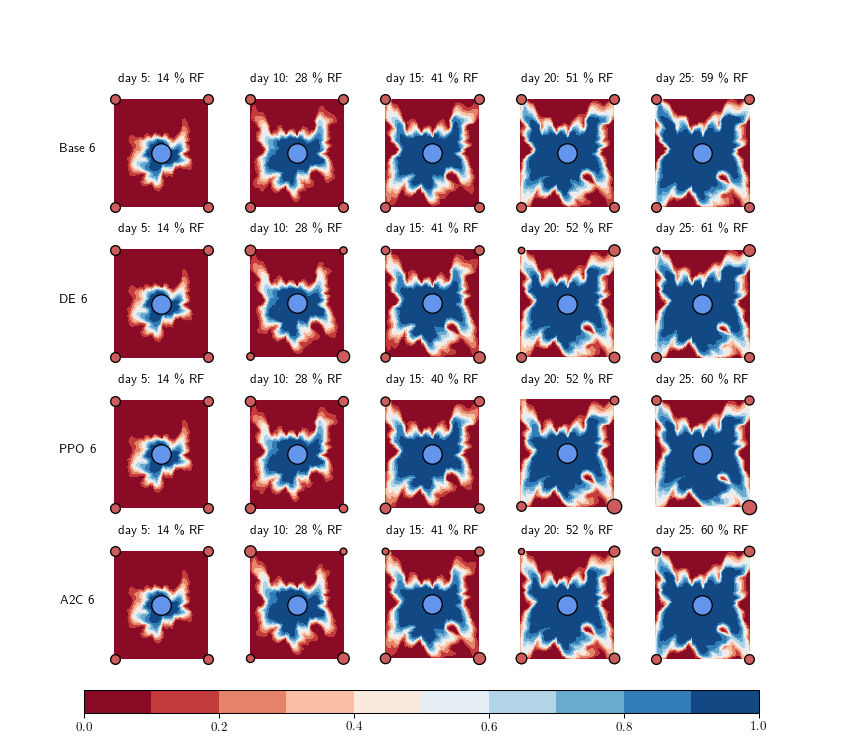

<IPython.core.display.Javascript object>


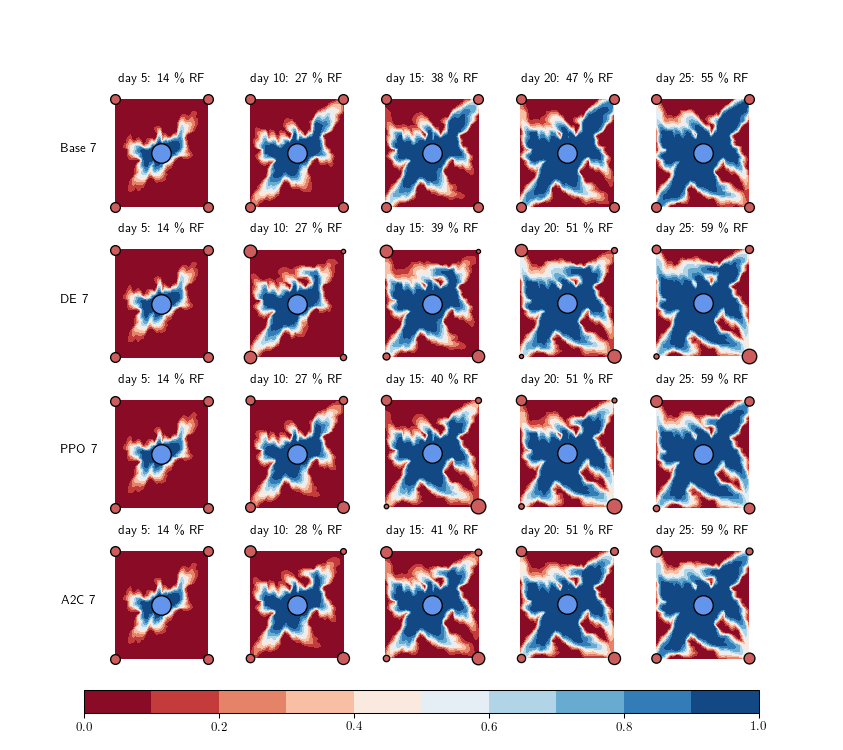

<IPython.core.display.Javascript object>


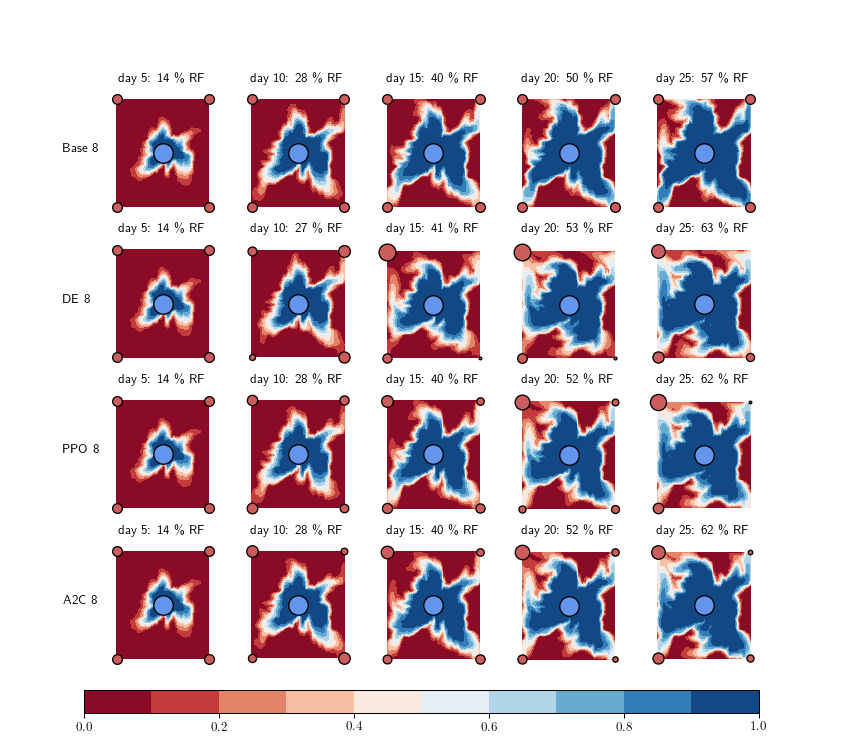

<IPython.core.display.Javascript object>


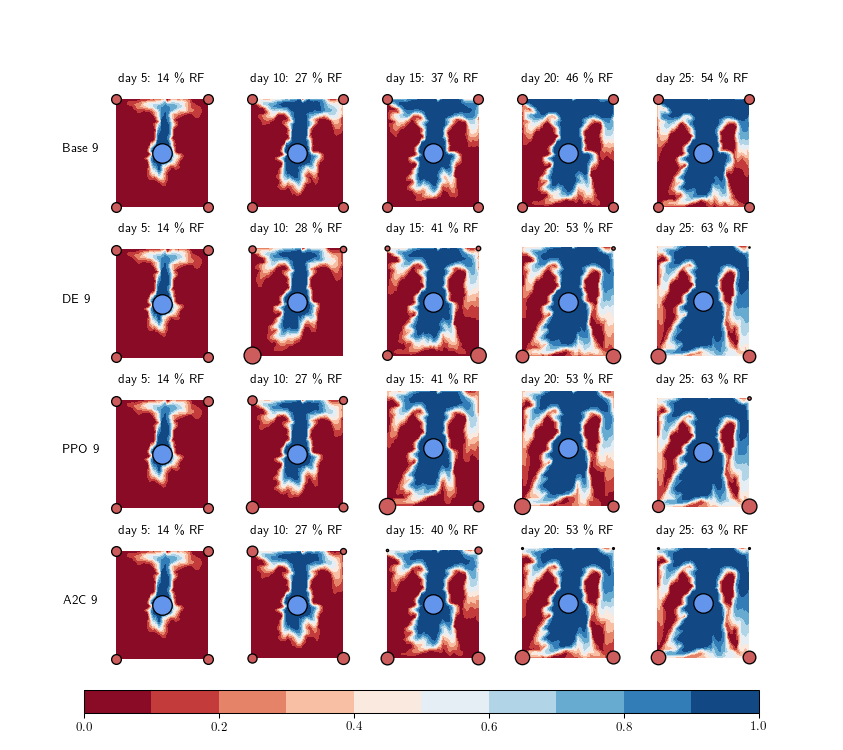

<IPython.core.display.Javascript object>


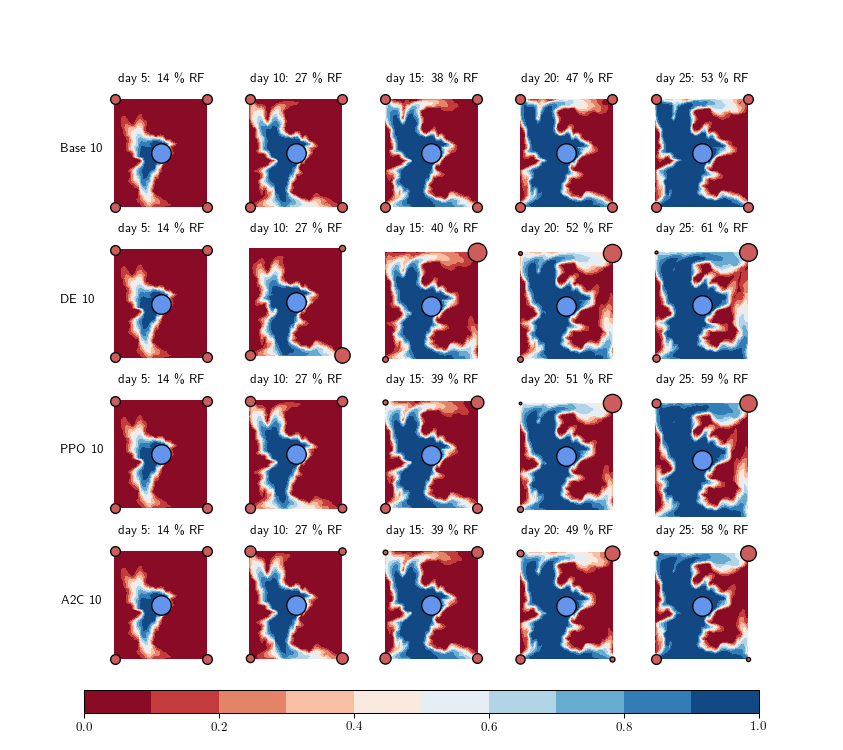

<IPython.core.display.Javascript object>


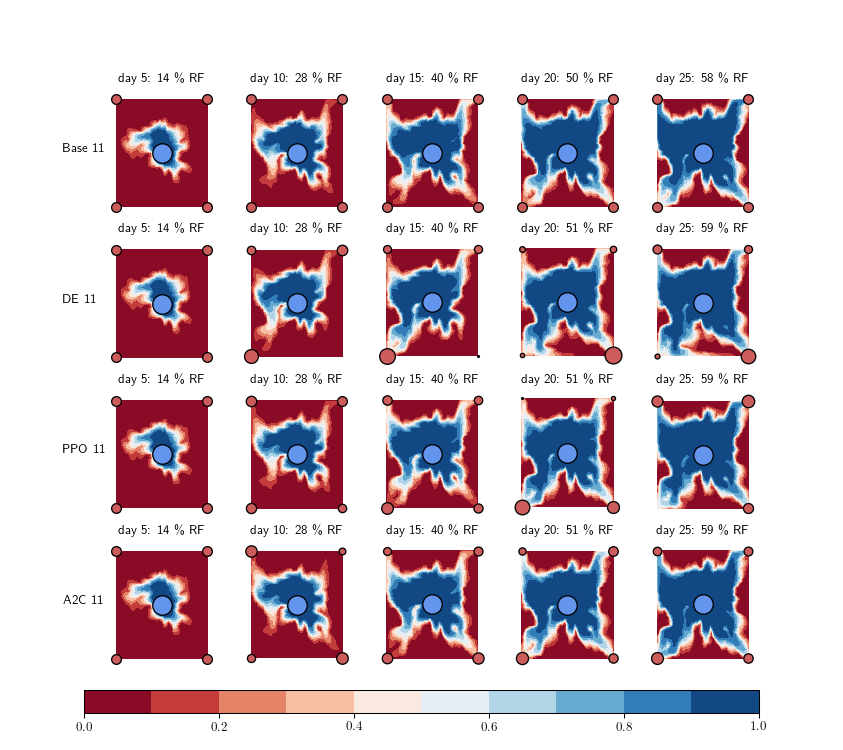

<IPython.core.display.Javascript object>


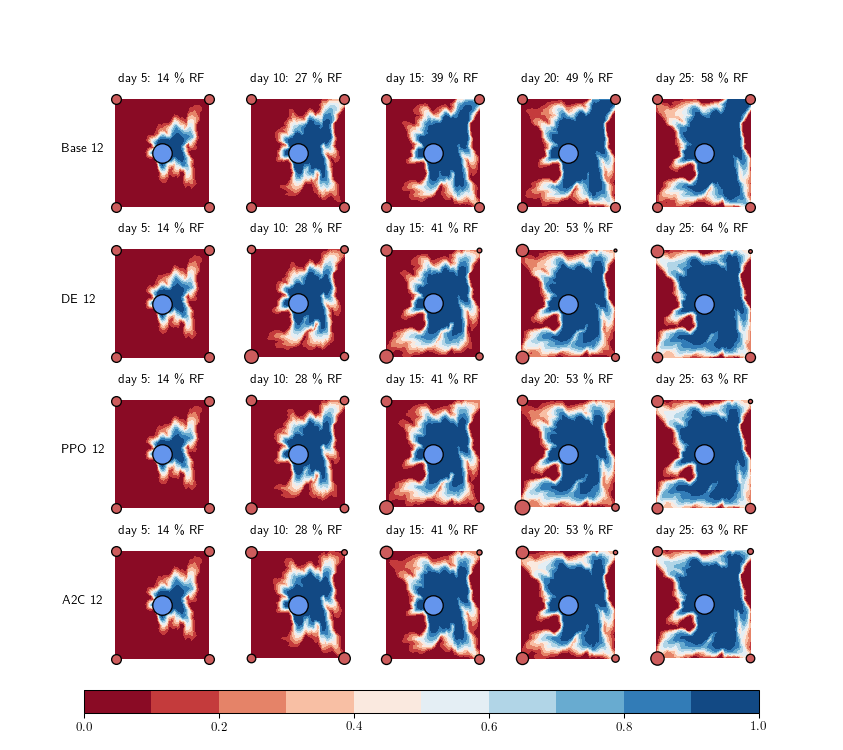

<IPython.core.display.Javascript object>


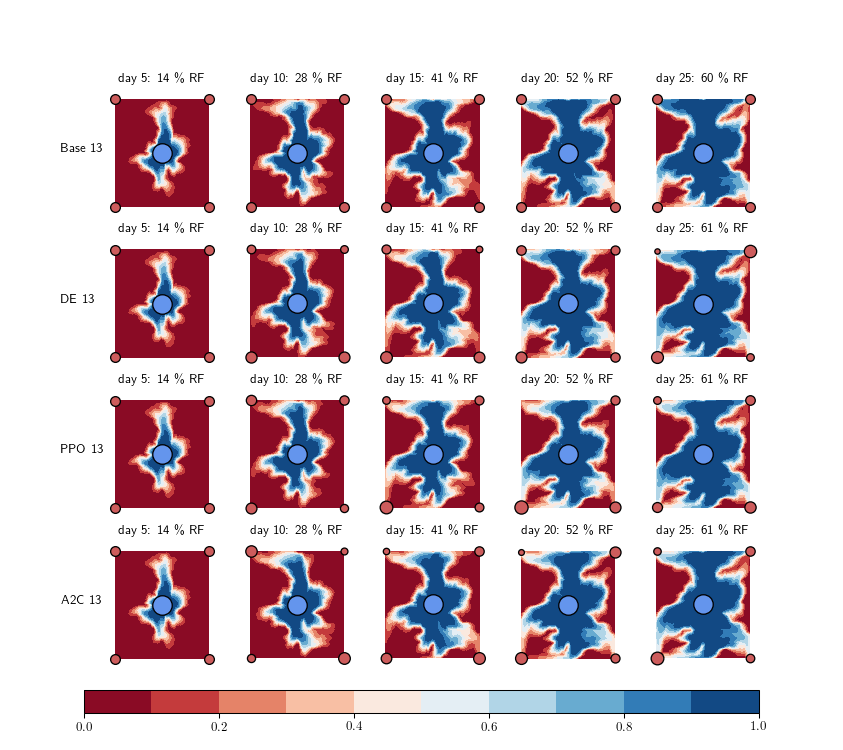

<IPython.core.display.Javascript object>


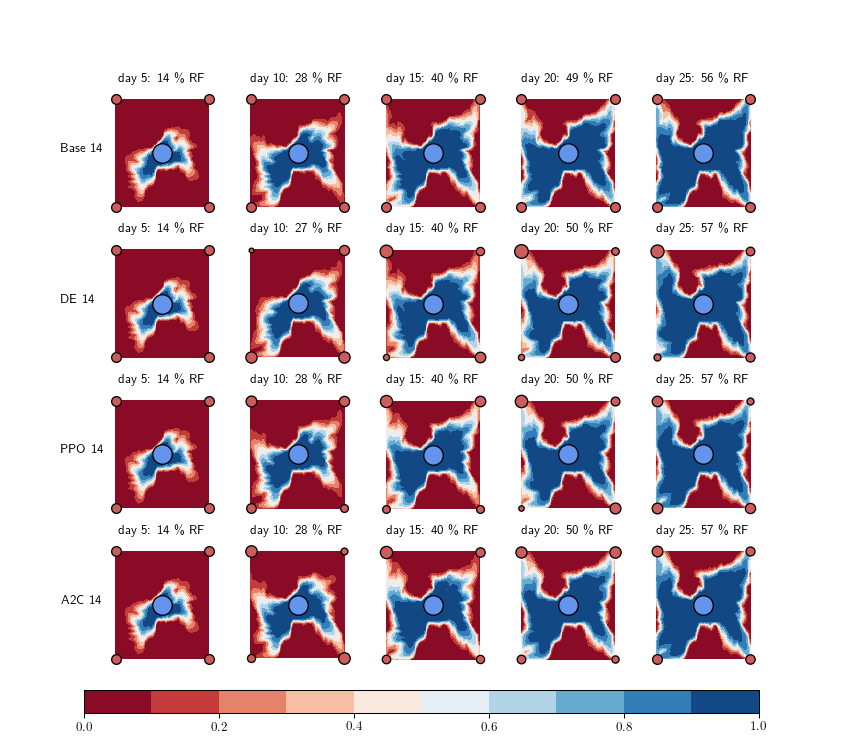

<IPython.core.display.Javascript object>


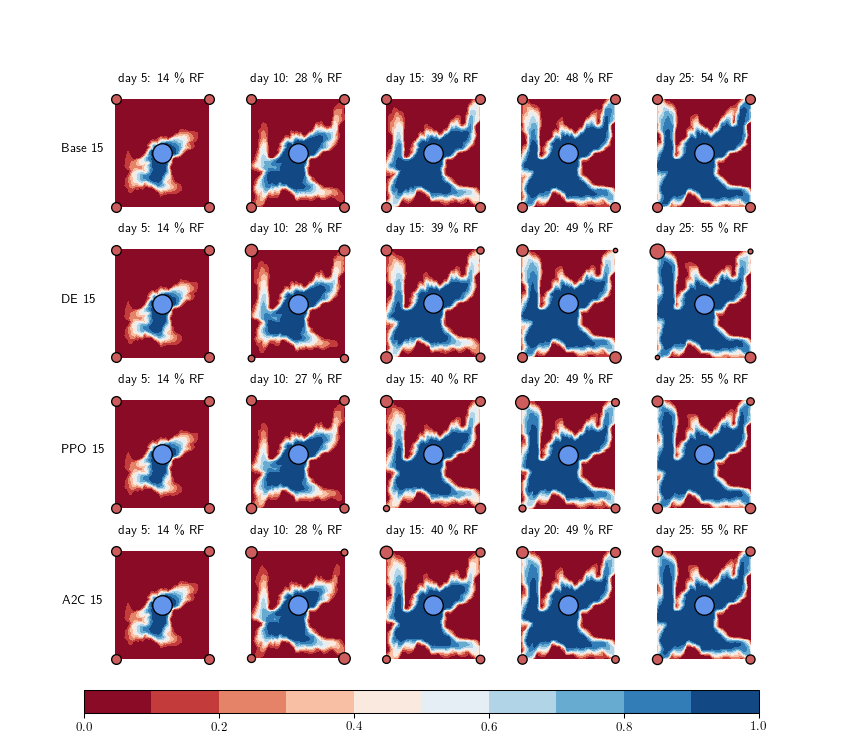

In [10]:
# plot actions (well schedules)
for i,(r_array, a_array, s_array, case_names) in enumerate(zip(r_array_eval, a_array_eval, s_array_eval, case_names_eval)):
    fig = plot_actions(r_array, a_array, s_array, case_names,
                 s_min=0, s_max=1, 
                 levels=10, show_wells=True, marker_size_ref=0.3,
                 time_per_step=5)
    fig.savefig(data_dir+'/'+case+'_a_eval_'+str(i)+'.pdf')